#Proyecto de Procesamiento de Alto Volumen de Datos  
## **Análisis de Seguridad, Pobreza y Educación en la Ciudad de Nueva York**

**Pontificia Universidad Javeriana – Facultad de Ingeniería**  
**Departamento de Ingeniería de Sistemas**  
**Asignatura:** Procesamiento de Alto Volumen de Datos  
**Docente:** John Corredor Franco, PhD  
**Periodo:** 2025-2  

---

### **Contexto del proyecto**

Este proyecto se desarrolla bajo la metodología **CRISP-DM (Cross Industry Standard Process for Data Mining)**, la cual guía el proceso de análisis de datos en seis fases:  
1. Entendimiento del negocio  
2. Entendimiento de los datos  
3. Preparación de los datos  
4. Modelado  
5. Evaluación  
6. Despliegue  

La presente entrega aborda las dos primeras fases, centradas en el **entendimiento del negocio y de los datos**, mediante la integración de información pública proveniente del portal [NYC Open Data](https://data.cityofnewyork.us/).  

El objetivo principal es **analizar la relación entre las condiciones socioeconómicas, educativas y los indicadores de seguridad (arrestos y accidentes viales)**, empleando **Apache Spark** como herramienta de procesamiento distribuido.

---

### **Objetivo del notebook**

Este notebook tiene como propósito documentar paso a paso el proceso de **configuración del entorno Spark**, **carga de los datasets seleccionados**, y la **descripción técnica inicial de los datos** utilizados en el proyecto:

- **NYPD Arrest Data (Year-to-Date)**  
  [https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc)

- **Motor Vehicle Collisions – Vehicles**  
  [https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4)

- **NYCgov Poverty Measure Data**  
  [https://data.cityofnewyork.us/City-Government/NYCgov-Poverty-Measure-Data/ct7s-vksw](https://data.cityofnewyork.us/City-Government/NYCgov-Poverty-Measure-Data/ct7s-vksw)

- **SAT Results (NYC Department of Education)**  
  [https://data.cityofnewyork.us/Education/2012-SAT-Results/zt9s-n5aj](https://data.cityofnewyork.us/Education/2012-SAT-Results/zt9s-n5aj)

---

### **Estructura del notebook**

1. **Configuración del entorno Spark**  
   - Creación de la sesión Spark.  
   - Verificación de instalación y recursos del cluster.  

2. **Carga de datasets en formato distribuido**  
   - Lectura de archivos CSV desde el entorno local o HDFS.  
   - Inspección de las primeras filas de cada dataset.  

3. **Descripción técnica y validación**  
   - Estructura de los datos (`printSchema()`).  
   - Conteo de registros y revisión general de atributos.  

4. **Exploración preliminar (EDA inicial)**  
   - Estadísticas descriptivas (`describe()`).  
   - Conteo de valores nulos y duplicados.  

5. **Conclusiones parciales**  
   - Observaciones sobre la calidad y completitud de los datos.  
   - Propuesta de próximos pasos (limpieza, integración y modelado).  

---

### **Equipo consultor**

- *Natalia Echeverry Salcedo*  
- *Sergio Felipe Barreto Cifuentes* 
- *Juan Diego Bernal Piñeros*  

---


In [1]:
# Módulos del sistema para manejo de rutas y paquetes.
import os
import sys
sys.path.append('/usr/lib/python3/dist-packages/')

# Librerías para análisis y visualización de datos.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import *

# Inicialización del entorno Spark.
import findspark
findspark.init()

# Funciones y estructuras principales de PySpark.
import pyspark.sql.functions as F
from pyspark.sql.functions import input_file_name, mean, col, split, regexp_extract, when, lit, isnan, count
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import *

In [2]:
# Se define la configuración básica de la aplicación en Spark.
configura = SparkConf()
configura.setAppName("Proyecto_NY_BigData")  # Nombre asignado a la sesión de Spark.

# Creación de la sesión principal de Spark.
# SparkSession es el punto de entrada para trabajar con DataFrames distribuidos.
spark03 = SparkSession.builder.config(conf=configura).getOrCreate()

# Inicializa el contexto SQL asociado a la sesión.
SQLContext(sparkContext=spark03.sparkContext, sparkSession=spark03)

# Obtiene o crea el contexto principal de Spark.
sparkContexto03 = spark03.sparkContext.getOrCreate()

# Confirmación en consola de la sesión activa.
print("Sesión creada: HPC004")
spark03  # Muestra información de la sesión activa.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/20 17:42:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/20 17:42:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/10/20 17:42:53 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Sesión creada: HPC004


**Carga de los datasets del proyecto**

In [3]:
import pandas as pd

# Arrestos del NYPD
arrestos_pd = pd.read_excel("NYPD_Arrest_Data_(Year_to_Date)_20251020.xlsx")
arrestos_df = spark03.createDataFrame(arrestos_pd)

In [4]:
# Colisiones vehiculares
colisiones_pd = pd.read_excel(
    "Motor_Vehicle_Collisions_-_Vehicles_20251020.xlsx",
    nrows=10000  # Solo las primeras 10k filas
)
colisiones_df = spark03.createDataFrame(colisiones_pd)

In [5]:
# Medición de pobreza
pobreza_pd = pd.read_excel("NYCgov_Poverty_Measure_Data_(2018)_20251020.xlsx")
pobreza_df = spark03.createDataFrame(pobreza_pd)

In [6]:
# Resultados SAT (educación)
sat_pd = pd.read_excel("SAT_Results.xlsx")
sat_df = spark03.createDataFrame(sat_pd)

In [7]:
# Verificación de carga
print("Registros en arrestos:", arrestos_df.count())
print("Registros en colisiones:", colisiones_df.count())
print("Registros en pobreza:", pobreza_df.count())
print("Registros en SAT:", sat_df.count())

Registros en arrestos: 143494


25/10/20 17:49:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Registros en colisiones: 10000
Registros en pobreza: 68273
Registros en SAT: 16


In [13]:
sat_df.show(5)
arrestos_df.show(5)
colisiones_df.show(5)
pobreza_df.show(5)

+--------------------+--------------------+
|          Unnamed: 0|          Unnamed: 1|
+--------------------+--------------------+
|Data Dictionary -...|                 NaN|
|                 NaN|                 NaN|
|             General|                 NaN|
|        Dataset Name|         SAT Results|
|         Agency Name|New York City Dep...|
+--------------------+--------------------+
only showing top 5 rows

+----------+-------------------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+----------------+-----------------+------------------------+
|ARREST_KEY|        ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD|        Latitude|        Longitude|New Georeferenced Column|
+----------+-------------------+-----

**Carga del dataset real del SAT (resultados 2012)**

In [10]:
# El dataset real contiene los puntajes promedio de lectura, matemáticas y escritura por escuela.
# Fuente oficial: NYC Department of Education (2012)
# https://data.cityofnewyork.us/Education/SAT-College-Board-2010-School-Level-Results/zt9s-n5aj/about_data

# Leer el archivo Excel real con pandas
sat_real_pd = pd.read_excel("SAT_(College_Board)_2010_School_Level_Results_20251020.xlsx")  

# Convertirlo a DataFrame de Spark
sat_real_df = spark03.createDataFrame(sat_real_pd)

print("Registros en SAT real:", sat_real_df.count())
print("Columnas en SAT real:", len(sat_real_df.columns))
print("\n=== Columnas del dataset SAT real ===")
print(sat_real_df.columns)

sat_real_df.show(5)

Registros en SAT real: 460
Columnas en SAT real: 6

=== Columnas del dataset SAT real ===
['DBN', 'School Name', 'Number of Test Takers', 'Critical Reading Mean', 'Mathematics Mean', 'Writing Mean']
+------+--------------------+---------------------+---------------------+----------------+------------+
|   DBN|         School Name|Number of Test Takers|Critical Reading Mean|Mathematics Mean|Writing Mean|
+------+--------------------+---------------------+---------------------+----------------+------------+
|01M292|Henry Street Scho...|                 31.0|                391.0|           425.0|       385.0|
|01M448|University Neighb...|                 60.0|                394.0|           419.0|       387.0|
|01M450|East Side Communi...|                 69.0|                418.0|           431.0|       402.0|
|01M458|SATELLITE ACADEMY...|                 26.0|                385.0|           370.0|       378.0|
|01M509|   CMSP HIGH SCHOOL |                  NaN|                  NaN|

**Descripción técnica de los datasets**

In [14]:
print("=== Estructura de Arrestos ===")
arrestos_df.printSchema()
arrestos_df.show(5)

print("=== Estructura de Colisiones ===")
colisiones_df.printSchema()
colisiones_df.show(5)

print("=== Estructura de Pobreza ===")
pobreza_df.printSchema()
pobreza_df.show(5)

print("=== Estructura de SAT (Educación) ===")
sat_df.printSchema()
sat_df.show(5)

print("=== Estructura de SAT 2012 (Educación) ===")
sat_real_df.printSchema()
sat_real_df.show(5)

=== Estructura de Arrestos ===
root
 |-- ARREST_KEY: long (nullable = true)
 |-- ARREST_DATE: timestamp (nullable = true)
 |-- PD_CD: long (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- KY_CD: double (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: long (nullable = true)
 |-- JURISDICTION_CODE: long (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: long (nullable = true)
 |-- Y_COORD_CD: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- New Georeferenced Column: string (nullable = true)

+----------+-------------------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+-----

**Análisis descriptivo inicial**

In [20]:
# Número de columnas por dataset
print("Columnas en Arrestos:", len(arrestos_df.columns))
print("Columnas en Colisiones:", len(colisiones_df.columns))
print("Columnas en Pobreza:", len(pobreza_df.columns))
print("Columnas en SAT:", len(sat_df.columns))

# Nombres de columnas (útil para revisión)
print("\n=== Columnas de Arrestos ===")
print(arrestos_df.columns)

print("\n=== Columnas de Colisiones ===")
print(colisiones_df.columns)

print("\n=== Columnas de Pobreza ===")
print(pobreza_df.columns)

print("\n=== Columnas de SAT ===")
print(sat_df.columns)

print("\n=== Columnas de SAT 2012 ===")
print(sat_real_df.columns)


# Conteo de valores nulos (por columna)
from pyspark.sql.functions import col, sum

def contar_nulos(df):
    return df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

print("\n=== Valores nulos en Arrestos ===")
contar_nulos(arrestos_df).show()

print("\n=== Valores nulos en Colisiones ===")
contar_nulos(colisiones_df).show()

print("\n=== Valores nulos en Pobreza ===")
contar_nulos(pobreza_df).show()

print("\n=== Valores nulos en SAT ===")
contar_nulos(sat_df).show()

print("\n=== Valores nulos en SAT 2012 ===")
contar_nulos(sat_real_df).show()


Columnas en Arrestos: 19
Columnas en Colisiones: 25
Columnas en Pobreza: 61
Columnas en SAT: 2

=== Columnas de Arrestos ===
['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'New Georeferenced Column']

=== Columnas de Colisiones ===
['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'VEHICLE_ID', 'STATE_REGISTRATION', 'VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'VEHICLE_YEAR', 'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 'DRIVER_SEX', 'DRIVER_LICENSE_STATUS', 'DRIVER_LICENSE_JURISDICTION', 'PRE_CRASH', 'POINT_OF_IMPACT', 'VEHICLE_DAMAGE', 'VEHICLE_DAMAGE_1', 'VEHICLE_DAMAGE_2', 'VEHICLE_DAMAGE_3', 'PUBLIC_PROPERTY_DAMAGE', 'PUBLIC_PROPERTY_DAMAGE_TYPE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2']

=== Columnas de Pobreza ===
['SERIALNO', 'SPORDER', 'PWGTP', 'WGTP', 'AGEP', 'CIT',

+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+---+---+---+---+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX|ENG|MSP|MAR|WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax|EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork|INTP_adj|MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_Threshold|OI_adj|PA_adj|Povunit_ID|Povunit_Rel|PreTax

**Análisis exploratorio del dataset SAT (Educación)**

In [24]:
# Mostrar estructura y columnas del dataset SAT
print("=== Columnas del dataset SAT ===")
print(sat_real_df.columns)

# Mostrar las primeras filas (para revisar qué variables numéricas tiene)
print("\n=== Vista previa del dataset SAT ===")
sat_real_df.show(10)

=== Columnas del dataset SAT ===
['DBN', 'School Name', 'Number of Test Takers', 'Critical Reading Mean', 'Mathematics Mean', 'Writing Mean']

=== Vista previa del dataset SAT ===
+------+--------------------+---------------------+---------------------+----------------+------------+
|   DBN|         School Name|Number of Test Takers|Critical Reading Mean|Mathematics Mean|Writing Mean|
+------+--------------------+---------------------+---------------------+----------------+------------+
|01M292|Henry Street Scho...|                 31.0|                391.0|           425.0|       385.0|
|01M448|University Neighb...|                 60.0|                394.0|           419.0|       387.0|
|01M450|East Side Communi...|                 69.0|                418.0|           431.0|       402.0|
|01M458|SATELLITE ACADEMY...|                 26.0|                385.0|           370.0|       378.0|
|01M509|   CMSP HIGH SCHOOL |                  NaN|                  NaN|             NaN|  

**Promedios generales del SAT (Lectura, Matemáticas, Escritura)**

In [25]:
# Verificar tipos de datos de cada columna
print("=== Tipos de datos en el dataset SAT real ===")
sat_real_df.printSchema()


=== Tipos de datos en el dataset SAT real ===
root
 |-- DBN: string (nullable = true)
 |-- School Name: string (nullable = true)
 |-- Number of Test Takers: double (nullable = true)
 |-- Critical Reading Mean: float (nullable = true)
 |-- Mathematics Mean: float (nullable = true)
 |-- Writing Mean: float (nullable = true)



In [26]:
from pyspark.sql.functions import col

# Convertir columnas a tipo numérico
sat_real_df = sat_real_df.withColumn("Critical Reading Mean", col("Critical Reading Mean").cast("float")) \
                         .withColumn("Mathematics Mean", col("Mathematics Mean").cast("float")) \
                         .withColumn("Writing Mean", col("Writing Mean").cast("float"))


In [28]:
# Limpiar filas con valores nulos en las columnas numéricas
sat_real_df_limpio = sat_real_df.na.drop(subset=["Critical Reading Mean", "Mathematics Mean", "Writing Mean"])

# Confirmar número de filas antes y después de limpiar
print("Filas antes:", sat_real_df.count())
print("Filas después de limpiar:", sat_real_df_limpio.count())


Filas antes: 460
Filas después de limpiar: 386


In [29]:
filas_totales = sat_real_df.count()
filas_validas = sat_real_df.na.drop(subset=["Critical Reading Mean", "Mathematics Mean", "Writing Mean"]).count()

print(f"Total: {filas_totales} | Sin nulos: {filas_validas} | Pérdidas: {filas_totales - filas_validas}")

Total: 460 | Sin nulos: 386 | Pérdidas: 74


In [30]:
from pyspark.sql.functions import avg, round

promedios_sat = sat_real_df_limpio.select(
    round(avg(col("Critical Reading Mean")), 2).alias("Promedio Lectura"),
    round(avg(col("Mathematics Mean")), 2).alias("Promedio Matemáticas"),
    round(avg(col("Writing Mean")), 2).alias("Promedio Escritura")
)

print("=== Promedios generales del SAT 2012 ===")
promedios_sat.show()

=== Promedios generales del SAT 2012 ===
+----------------+--------------------+------------------+
|Promedio Lectura|Promedio Matemáticas|Promedio Escritura|
+----------------+--------------------+------------------+
|          404.25|              412.94|            397.69|
+----------------+--------------------+------------------+



In [35]:
# ===============================================================
# 4. Selección de datos a utilizar
# ===============================================================

from pyspark.sql import DataFrame

# Diccionario con los datasets seleccionados
datasets_info = {
    "NYPD Arrest Data (Year-to-Date)": "NYPD_Arrest_Data_(Year_to_Date)_20251020.xlsx",
    "Motor Vehicle Collisions – Vehicles": "Motor_Vehicle_Collisions_-_Vehicles_20251020.xlsx",
    "NYCgov Poverty Measure Data": "NYCgov_Poverty_Measure_Data_(2018)_20251020.xlsx",
    "SAT Results (Education)": "SAT_Results.xlsx"
}

# Cargar los archivos seleccionados como DataFrames de PySpark
arrestos_df = spark03.createDataFrame(pd.read_excel(datasets_info["NYPD Arrest Data (Year-to-Date)"]))
colisiones_df = spark03.createDataFrame(pd.read_excel(datasets_info["Motor Vehicle Collisions – Vehicles"],nrows=10000))
pobreza_df = spark03.createDataFrame(pd.read_excel(datasets_info["NYCgov Poverty Measure Data"]))
sat_df = spark03.createDataFrame(pd.read_excel(datasets_info["SAT Results (Education)"]))

# Verificar estructura general de los datasets seleccionados
print("=== Selección final de datasets a utilizar ===\n")
for nombre, df in {
    "Arrestos": arrestos_df,
    "Colisiones": colisiones_df,
    "Pobreza": pobreza_df,
    "SAT (Educación)": sat_df
}.items():
    print(f"{nombre}: {df.count()} registros, {len(df.columns)} columnas")
    df.printSchema()
    print("---------------------------------------------")



=== Selección final de datasets a utilizar ===



Arrestos: 143494 registros, 19 columnas
root
 |-- ARREST_KEY: long (nullable = true)
 |-- ARREST_DATE: timestamp (nullable = true)
 |-- PD_CD: long (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- KY_CD: double (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: long (nullable = true)
 |-- JURISDICTION_CODE: long (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: long (nullable = true)
 |-- Y_COORD_CD: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- New Georeferenced Column: string (nullable = true)

---------------------------------------------
Colisiones: 10000 registros, 25 columnas
root
 |-- UNIQUE_ID: long (nullable = true)
 |-- COLLISION_ID: long (null

**Exploración de los Datos**

In [52]:
# Exploración de los datasets
for nombre, df in {
    "Arrestos": arrestos_df,
    "Colisiones": colisiones_df,
    "Pobreza": pobreza_df,
    "SAT (Educación)": sat_real_df
}.items():
    print(f"\n=== Estructura del dataset {nombre} ===")
    df.printSchema()
    print("\nColumnas:", df.columns)
    print("\nVista previa:")
    df.show(5)
    
    print("\n=== Valores nulos en", nombre, "===")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()


=== Estructura del dataset Arrestos ===
root
 |-- ARREST_KEY: long (nullable = true)
 |-- ARREST_DATE: timestamp (nullable = true)
 |-- PD_CD: long (nullable = true)
 |-- PD_DESC: string (nullable = true)
 |-- KY_CD: double (nullable = true)
 |-- OFNS_DESC: string (nullable = true)
 |-- LAW_CODE: string (nullable = true)
 |-- LAW_CAT_CD: string (nullable = true)
 |-- ARREST_BORO: string (nullable = true)
 |-- ARREST_PRECINCT: long (nullable = true)
 |-- JURISDICTION_CODE: long (nullable = true)
 |-- AGE_GROUP: string (nullable = true)
 |-- PERP_SEX: string (nullable = true)
 |-- PERP_RACE: string (nullable = true)
 |-- X_COORD_CD: long (nullable = true)
 |-- Y_COORD_CD: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- New Georeferenced Column: string (nullable = true)


Columnas: ['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CO

+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|         0|          0|    0|      0|    0|        0|       0|         0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|                       0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+------

+---------+------------+----------+----------+----------+------------------+------------+------------+-------------+------------+----------------+-----------------+----------+---------------------+---------------------------+---------+---------------+--------------+----------------+----------------+----------------+----------------------+---------------------------+---------------------+---------------------+
|UNIQUE_ID|COLLISION_ID|CRASH_DATE|CRASH_TIME|VEHICLE_ID|STATE_REGISTRATION|VEHICLE_TYPE|VEHICLE_MAKE|VEHICLE_MODEL|VEHICLE_YEAR|TRAVEL_DIRECTION|VEHICLE_OCCUPANTS|DRIVER_SEX|DRIVER_LICENSE_STATUS|DRIVER_LICENSE_JURISDICTION|PRE_CRASH|POINT_OF_IMPACT|VEHICLE_DAMAGE|VEHICLE_DAMAGE_1|VEHICLE_DAMAGE_2|VEHICLE_DAMAGE_3|PUBLIC_PROPERTY_DAMAGE|PUBLIC_PROPERTY_DAMAGE_TYPE|CONTRIBUTING_FACTOR_1|CONTRIBUTING_FACTOR_2|
+---------+------------+----------+----------+----------+------------------+------------+------------+-------------+------------+----------------+-----------------+----------

+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+---+---+---+---+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX|ENG|MSP|MAR|WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax|EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork|INTP_adj|MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_Threshold|OI_adj|PA_adj|Povunit_ID|Povunit_Rel|PreTax

Se identifican falsos positivos en la identificacion de valores nulos en la tabla SAT

**Reporte de Calidad de Datos**

In [37]:
from pyspark.sql import functions as F

# Revisión de duplicados y valores nulos
for nombre, df in {
    "Arrestos": arrestos_df,
    "Colisiones": colisiones_df,
    "Pobreza": pobreza_df,
    "SAT (Educación)": sat_df
}.items():
    print(f"\n=== Reporte de calidad del dataset {nombre} ===")
    
    # Número total de filas
    total = df.count()
    
    # Duplicados
    duplicados = df.count() - df.dropDuplicates().count()
    
    # Valores nulos
    nulos = df.select([
        F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns
    ])
    
    print(f"Total de filas: {total}")
    print(f"Registros duplicados: {duplicados}")
    print("\nValores nulos por columna:")
    nulos.show()
    print("-" * 60)


=== Reporte de calidad del dataset Arrestos ===


Total de filas: 143494
Registros duplicados: 0

Valores nulos por columna:


+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|PD_DESC|KY_CD|OFNS_DESC|LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|PERP_RACE|X_COORD_CD|Y_COORD_CD|Latitude|Longitude|New Georeferenced Column|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+--------+---------+----------+----------+--------+---------+------------------------+
|         0|          0|    0|      0|    0|        0|       0|         0|          0|              0|                0|        0|       0|        0|         0|         0|       0|        0|                       0|
+----------+-----------+-----+-------+-----+---------+--------+----------+-----------+---------------+-----------------+---------+------

Total de filas: 10000
Registros duplicados: 0

Valores nulos por columna:
+---------+------------+----------+----------+----------+------------------+------------+------------+-------------+------------+----------------+-----------------+----------+---------------------+---------------------------+---------+---------------+--------------+----------------+----------------+----------------+----------------------+---------------------------+---------------------+---------------------+
|UNIQUE_ID|COLLISION_ID|CRASH_DATE|CRASH_TIME|VEHICLE_ID|STATE_REGISTRATION|VEHICLE_TYPE|VEHICLE_MAKE|VEHICLE_MODEL|VEHICLE_YEAR|TRAVEL_DIRECTION|VEHICLE_OCCUPANTS|DRIVER_SEX|DRIVER_LICENSE_STATUS|DRIVER_LICENSE_JURISDICTION|PRE_CRASH|POINT_OF_IMPACT|VEHICLE_DAMAGE|VEHICLE_DAMAGE_1|VEHICLE_DAMAGE_2|VEHICLE_DAMAGE_3|PUBLIC_PROPERTY_DAMAGE|PUBLIC_PROPERTY_DAMAGE_TYPE|CONTRIBUTING_FACTOR_1|CONTRIBUTING_FACTOR_2|
+---------+------------+----------+----------+----------+------------------+------------+-----------

Total de filas: 68273
Registros duplicados: 0

Valores nulos por columna:
+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+---+---+---+---+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+--------+-------------+----------+---------------+---------+----------+--------+--------+--------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+-------+---------------+--------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX|ENG|MSP|MAR|WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax|EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork|INTP_adj|MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Thresh

**Filtros, Limpieza y Transformaciones Iniciales**

In [38]:
total = arrestos_df.count()
sin_duplicados = arrestos_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

[Stage 204:====================================================>(165 + 3) / 168]

Registros totales: 143494
Registros únicos:  143494
Duplicados:        0


In [39]:
total = colisiones_df.count()
sin_duplicados = colisiones_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

Registros totales: 10000
Registros únicos:  10000
Duplicados:        0


In [40]:
total = pobreza_df.count()
sin_duplicados = pobreza_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

[Stage 222:====================================================>(167 + 1) / 168]

Registros totales: 68273
Registros únicos:  68273
Duplicados:        0


In [71]:
total = sat_real_df.count()
sin_duplicados = sat_df.dropDuplicates().count()

print(f"Registros totales: {total}")
print(f"Registros únicos:  {sin_duplicados}")
print(f"Duplicados:        {total - sin_duplicados}")

[Stage 350:===================================>                (114 + 24) / 168]

Registros totales: 460
Registros únicos:  13
Duplicados:        447


In [61]:
#Verificar la calidad de los nulos y evitar falsos positivo
from pyspark.sql.functions import when, col, trim, lower

def normalizar_nulos(df):
    for c in df.columns:
        df = df.withColumn(
            c,
            when(
                (trim(lower(col(c))).isin("", "na", "n/a", "null", "none", "NaN")), None
            ).otherwise(col(c))
        )
    return df

arrestos_df = normalizar_nulos(arrestos_df)
pobreza_df = normalizar_nulos(pobreza_df)
colisiones_df = normalizar_nulos(colisiones_df)
sat_real_df = normalizar_nulos(sat_real_df)

In [70]:
from pyspark.sql.functions import col, sum, isnan

def contar_nulos_completo(df):
    return df.select([
        sum((col(c).isNull() | isnan(col(c))).cast("int")).alias(c)
        for c in df.columns
    ])

# Ejemplo con tu dataset SAT
print("=== Conteo de nulos reales SAT===")
contar_nulos_completo(sat_real_df).show(vertical=True)

print("=== Conteo de nulos reales Pobreza===")
contar_nulos_completo(pobreza_df).show(vertical=True)


=== Conteo de nulos reales SAT===


-RECORD 0--------------------
 DBN                   | 0   
 School Name           | 0   
 Number of Test Takers | 74  
 Critical Reading Mean | 74  
 Mathematics Mean      | 74  
 Writing Mean          | 74  

=== Conteo de nulos reales Pobreza===


25/10/20 19:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1120.1 KiB
[Stage 344:===================================================> (163 + 5) / 168]

-RECORD 0-----------------
 SERIALNO         | 0     
 SPORDER          | 0     
 PWGTP            | 0     
 WGTP             | 0     
 AGEP             | 0     
 CIT              | 0     
 REL              | 0     
 SCH              | 0     
 SCHG             | 0     
 SCHL             | 2107  
 SEX              | 0     
 ESR              | 11798 
 LANX             | 3533  
 ENG              | 37557 
 MSP              | 11021 
 MAR              | 0     
 WKW              | 31394 
 WKHP             | 0     
 DIS              | 0     
 JWTR             | 34956 
 NP               | 0     
 TEN              | 0     
 HHT              | 0     
 AgeCateg         | 0     
 Boro             | 0     
 CitizenStatus    | 0     
 EducAttain       | 2107  
 EST_Childcare    | 0     
 EST_Commuting    | 0     
 EST_EITC         | 0     
 EST_FICAtax      | 0     
 EST_HEAP         | 0     
 EST_Housing      | 0     
 EST_IncomeTax    | 0     
 EST_MOOP         | 0     
 EST_Nutrition    | 0     
 

In [89]:
# Limpiar filas con valores nulos en las columnas numéricas
pobreza_df_limpio = pobreza_df.na.drop(subset=["WKW", "JWTR", "EducAttain"])

# Confirmar número de filas antes y después de limpiar
print("Filas antes:", pobreza_df.count())
print("Filas después de limpiar:", pobreza_df_limpio.count())

Filas antes: 68273


[Stage 425:==================================================>  (160 + 8) / 168]

Filas después de limpiar: 33317


Con los valores nulos normalizados se toma la decision de no borrar o llenar la informacion de forma precipitada y en su lugar transformar atributos valiosos para representarlos y sugerir preguntas de negocio

In [107]:
pobreza_df02 = pobreza_df.withColumn("Sexo", F.when((pobreza_df.SEX == 2),'Female')
    .when((pobreza_df.SEX == 1),'Male')
    .otherwise('NI')
                      )

In [102]:
pobreza_df03 = pobreza_df02.withColumn("Matriculado", F.when((pobreza_df02.SCH == 1),'No asistio')
    .when((pobreza_df02.SCH == 2),'Publica')
    .when((pobreza_df02.SCH == 3),'Privada')
    .otherwise('N/A')
                      )

In [103]:
pobreza_df04 = pobreza_df03.withColumn("Estado Civil", F.when((pobreza_df03.MAR == 1),'Casado')
    .when((pobreza_df03.MAR== 2),'Viudo')
    .when((pobreza_df03.MAR== 3),'Divorciado')
    .when((pobreza_df03.MAR== 4),'Separado')
    .otherwise('Nunca se caso')
                      )

In [104]:
pobreza_df05 = pobreza_df04.withColumn("Etnicidad", F.when((pobreza_df04.Ethnicity == 1),'Blanco')
    .when((pobreza_df04.Ethnicity== 2),'Negro')
    .when((pobreza_df04.Ethnicity== 3),'Asiatico')
    .when((pobreza_df04.Ethnicity== 4),'Hispano')
    .otherwise('Otro')
                      )

In [121]:
pobreza_df05.show(5)


+--------+-------+-----+----+----+---+---+---+----+----+---+---+----+---+---+---+---+----+---+----+---+---+---+--------+----+-------------+----------+-------------+-------------+--------+-----------+--------+-----------+-------------+---------+-------------+----------+---------------+---------+----------+--------+---------+---------+-------------+---------------+----------+----------------+------------+-------------+------+------+----------+-----------+---------------+--------+--------+--------+--------+---------+---------------+---------+------+-----------+-------------+---------+
|SERIALNO|SPORDER|PWGTP|WGTP|AGEP|CIT|REL|SCH|SCHG|SCHL|SEX|ESR|LANX|ENG|MSP|MAR|WKW|WKHP|DIS|JWTR| NP|TEN|HHT|AgeCateg|Boro|CitizenStatus|EducAttain|EST_Childcare|EST_Commuting|EST_EITC|EST_FICAtax|EST_HEAP|EST_Housing|EST_IncomeTax| EST_MOOP|EST_Nutrition|EST_PovGap|EST_PovGapIndex|Ethnicity|FamType_PU|FTPTWork| INTP_adj| MRGP_adj|NYCgov_Income|NYCgov_Pov_Stat|NYCgov_REL|NYCgov_Threshold|Off_Pov_Stat|Off_T

25/10/20 20:35:18 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB


In [122]:
#Se define un grafico para evaluar la distribucion de ciertas variables claves y se evalua sobre las tranformaciones de la tabla de pobreza
def grafico_distribucion(df, columna, top_n=10):
    """
    Muestra un gráfico de barras con la distribución de una columna cualitativa.
    
    Args:
        df (DataFrame): DataFrame de Spark
        columna (str): nombre de la columna a graficar
        top_n (int): número de categorías más frecuentes a mostrar
    """
    # 1️⃣ Contar las frecuencias en Spark
    conteo = (
        df.groupBy(columna)
          .agg(count("*").alias("Frecuencia"))
          .orderBy(col("Frecuencia").desc())
          .limit(top_n)
    )
    
    # 2️⃣ Convertir a Pandas para graficar
    conteo_pd = conteo.toPandas()
    
    # 3️⃣ Crear el gráfico
    plt.figure(figsize=(10, 6))
    sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")
    plt.title(f"Distribución de '{columna}' ")
    plt.xlabel("Frecuencia")
    plt.ylabel(columna)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3081455/18107117.py:24: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


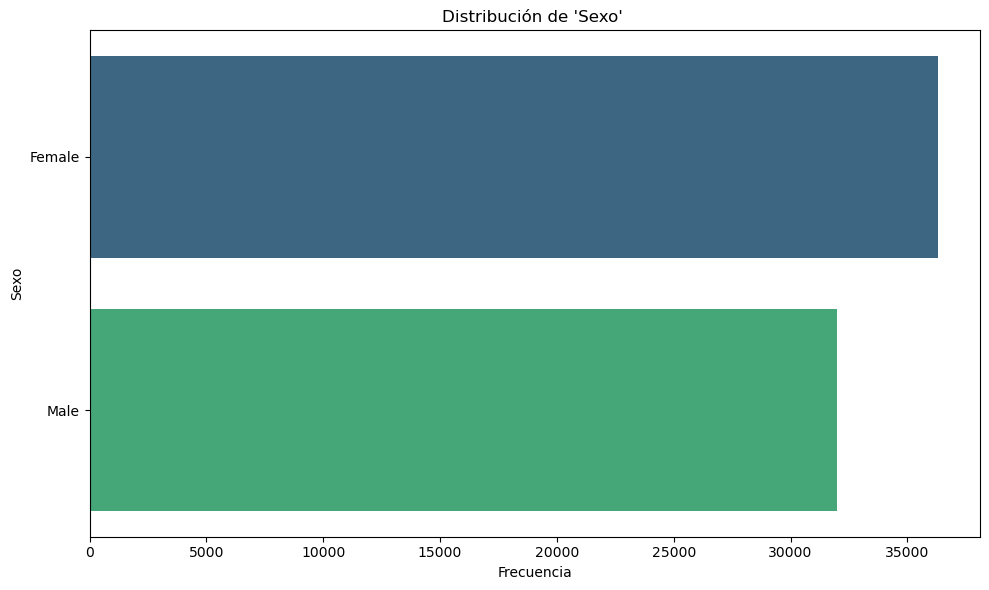

In [123]:
grafico_distribucion(pobreza_df05, "Sexo", top_n=3)

/tmp/ipykernel_3081455/18107117.py:24: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


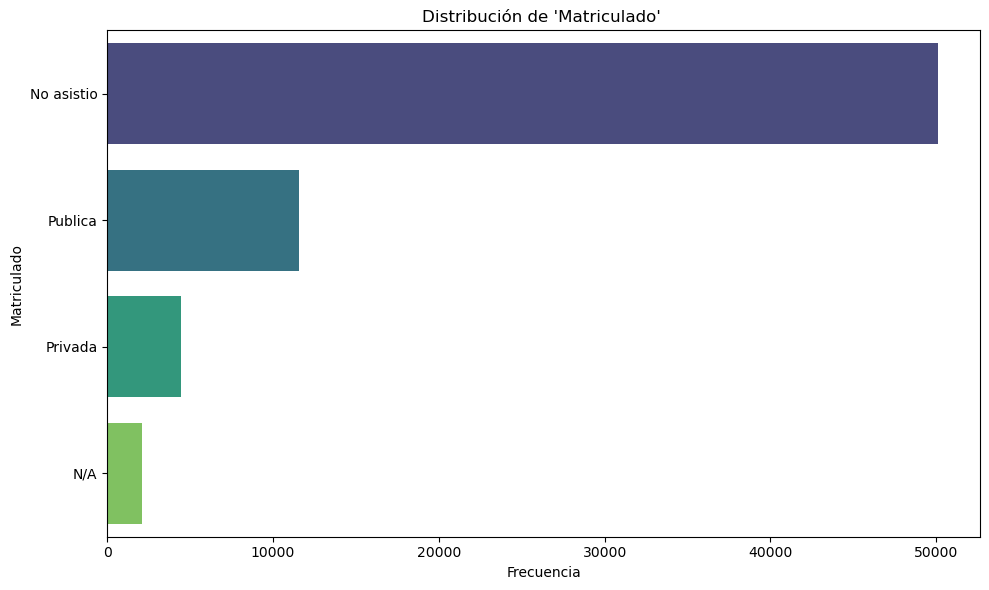

In [124]:
grafico_distribucion(pobreza_df05, "Matriculado", top_n=4)

/tmp/ipykernel_3081455/18107117.py:24: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


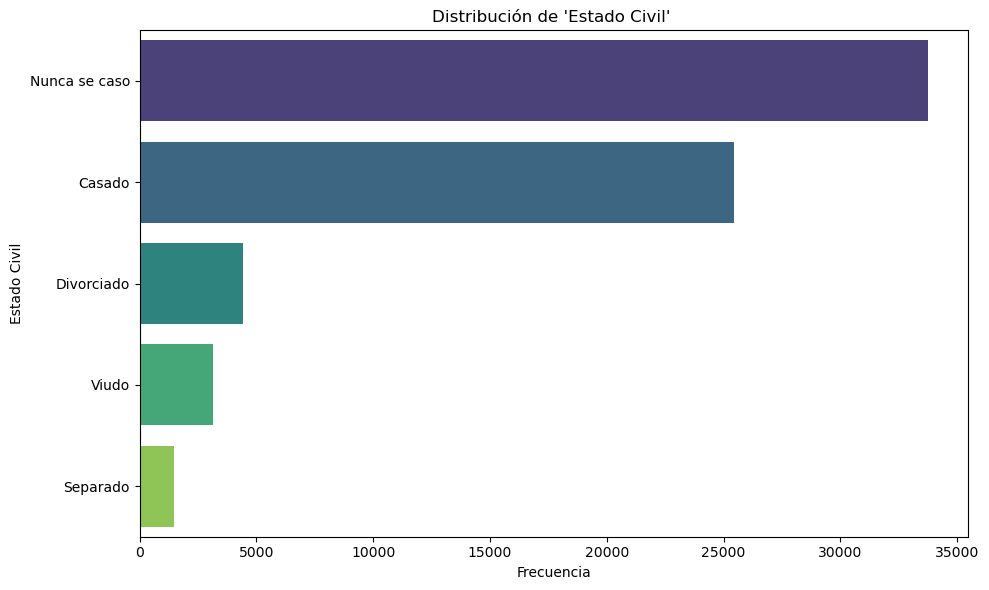

In [125]:
grafico_distribucion(pobreza_df05, "Estado Civil", top_n=5)

/tmp/ipykernel_3081455/18107117.py:24: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=conteo_pd, x="Frecuencia", y=columna, palette="viridis")


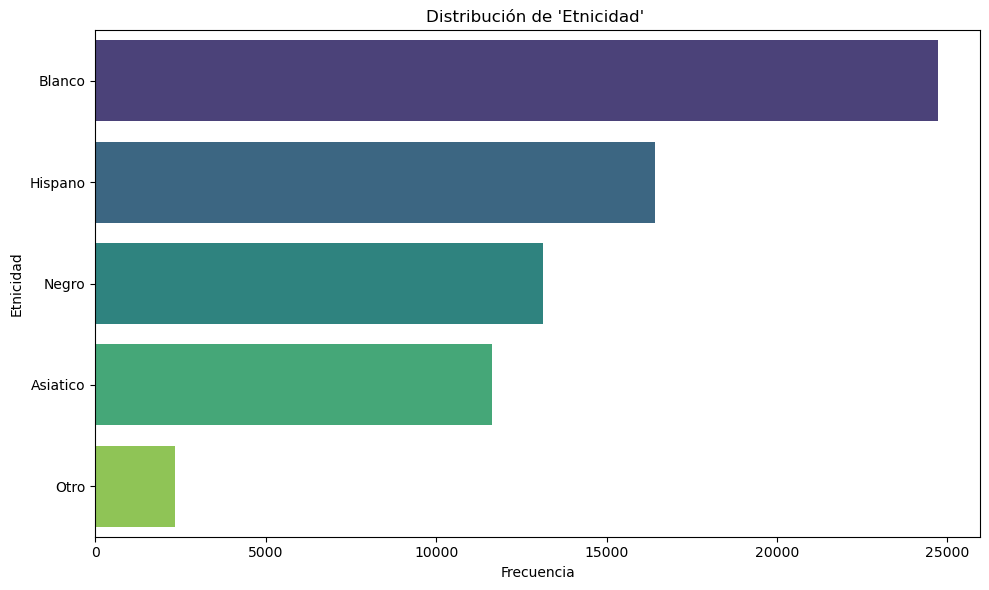

In [126]:
grafico_distribucion(pobreza_df05, "Etnicidad", top_n=5)